In [61]:
import pandas as pd
import ast

from matplotlib.pyplot import suptitle
from scipy.stats import skewnorm

In [84]:
df = pd.read_csv('orig_data/all_ratings.csv')
df.head()

,userId,rating,title
0,1,4.0,Toy Story (1995)
1,1,4.0,Grumpier Old Men (1995)
2,1,4.0,Heat (1995)
3,1,5.0,Seven (a.k.a. Se7en) (1995)
4,1,5.0,"Usual Suspects, The (1995)"


In [85]:
len(df)

100836

In [63]:
# dfx = pd.read_csv('good/llama70b_rp_all.csv')
# len(dfx)

In [86]:
mean_rating = df['rating'].mean()
std_rating = df['rating'].std()
a = -3  # Adjust 'a' to control the skewness
skewed_data = skewnorm.rvs(a, loc=mean_rating, scale=std_rating, size=len(df))

In [87]:
df['random_rating'] = skewed_data

In [93]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import glob

def compare_ratings(merged_df):
    true_ratings = merged_df['rating']
    predicted_ratings = merged_df['predicted_rating']

    # Calculate the error metrics
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    r2 = r2_score(true_ratings, predicted_ratings)

    return mae, rmse, r2

csv_files = [f for f in glob.glob(os.path.join('llm_output_processed', "*.csv"))] + ['user_based/trad_user_ratings.csv']
csv_files.sort()
maes = []
rmses = []
r_sq = []

for file in csv_files:
    predicted_df = pd.read_csv(file).dropna()
    merged_df = pd.merge(df, predicted_df, on='title')

    mae, rmse, r2 = compare_ratings(merged_df)
    maes.append(mae)
    rmses.append(rmse)
    r_sq.append(r2)

    print(f"Results for {file}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R-squared: {r2:.4f}")
    print("-" * 40)

mae = mean_absolute_error(df['rating'], df['random_rating'])
rmse = np.sqrt(mean_squared_error(df['rating'], df['random_rating']))
r2 = r2_score(df['rating'], df['random_rating'])
maes.append(mae)
rmses.append(rmse)
r_sq.append(r2)
print(f"Results for Random:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R-squared: {r2:.4f}")
print("-" * 40)
models = [x.split('/')[1].split('.')[0] for x in csv_files] + ['Random']
data = {
    'models': models,
    'MAE': maes,
    'RMSE': rmses,
    'R_SQ': r_sq
}
df1 = pd.DataFrame(data)

Results for llm_output_processed/llama70b_rp.csv:
  MAE: 0.8110
  RMSE: 1.0929
  R-squared: -0.2260
----------------------------------------
Results for llm_output_processed/llama70b_rp_10.csv:
  MAE: 0.8090
  RMSE: 1.0940
  R-squared: -0.2244
----------------------------------------
Results for llm_output_processed/llama70b_rp_all.csv:
  MAE: 0.7921
  RMSE: 1.0842
  R-squared: -0.2035
----------------------------------------
Results for llm_output_processed/qwen_rp.csv:
  MAE: 0.8197
  RMSE: 1.1145
  R-squared: -0.2776
----------------------------------------
Results for llm_output_processed/qwen_rp_10.csv:
  MAE: 0.8260
  RMSE: 1.1237
  R-squared: -0.2945
----------------------------------------
Results for llm_output_processed/qwen_rp_all.csv:
  MAE: 0.8328
  RMSE: 1.1436
  R-squared: -0.3426
----------------------------------------
Results for user_based/trad_user_ratings.csv:
  MAE: 0.6924
  RMSE: 0.9008
  R-squared: 0.1701
----------------------------------------
Results for Rand

,models,MAE,RMSE,R_SQ
0,llama70b_rp,0.811022,1.092883,-0.226004
1,llama70b_rp_10,0.809015,1.093993,-0.224413
2,llama70b_rp_all,0.792142,1.084214,-0.203497
3,qwen_rp,0.819733,1.114509,-0.277600
4,qwen_rp_10,0.826048,1.123688,-0.294470


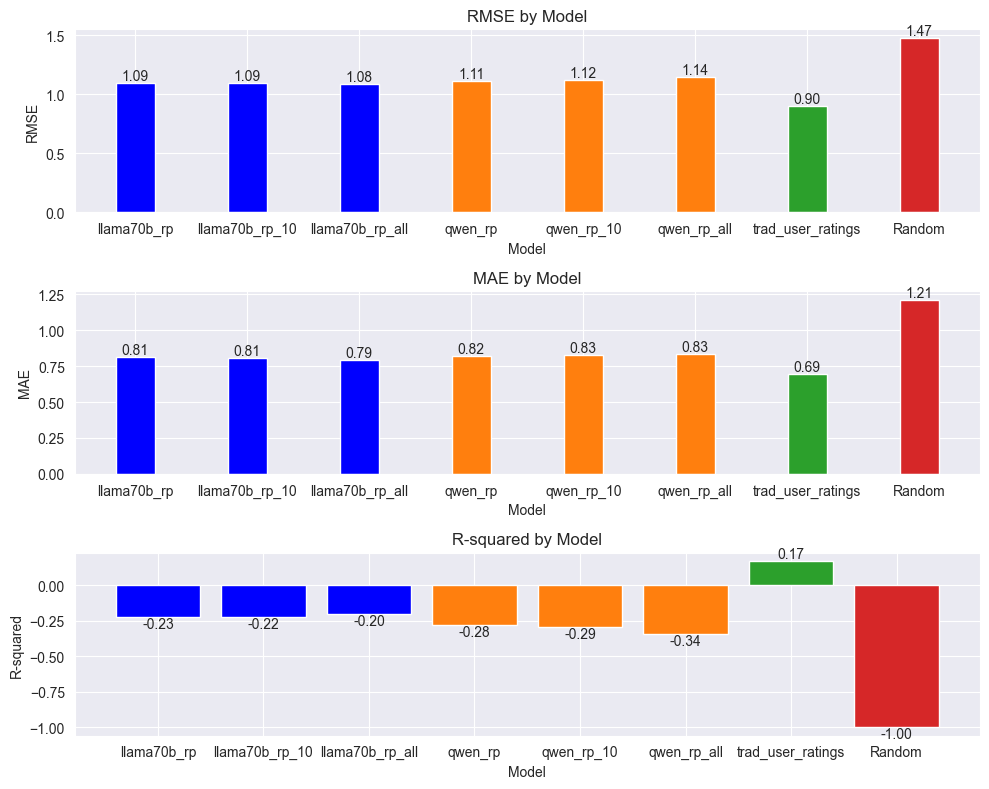

In [108]:
import matplotlib.pyplot as plt

def determine_color(filename):
    if filename.startswith('qwen'):
        return '#ff7f0e'
    elif filename.startswith('trad'):
        return '#2ca02c'
    elif filename.startswith('Random'):
        return '#d62728'
    else:
        return 'blue'  # Default color
# Bar chart for MAE and RMSE
models = df1['models']
rmses = df1['RMSE']
maes = df1['MAE']
r_sq = df1['R_SQ']
bar_width = 0.35
index = np.arange(len(models))

colors = [determine_color(model) for model in models]

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# Plot RMSE by Model
bars = axes[0].bar(index + bar_width / 2, rmses, bar_width, label='RMSE', color=colors)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE by Model')
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(models)
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')


# Plot MAE by Model
bars = axes[1].bar(index + bar_width / 2, maes, bar_width, label='MAE', color=colors)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE by Model')
axes[1].set_xticks(index + bar_width / 2)
axes[1].set_xticklabels(models)
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Plot R-squared by Model
bars = axes[2].bar(models, r_sq, color=colors)
axes[2].set_xlabel('Model')
axes[2].set_ylabel('R-squared')
axes[2].set_title('R-squared by Model')
for bar in bars:
    height = bar.get_height()
    if height < 0:
        axes[2].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='top')
    else:
        axes[2].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure
plt.savefig('combined_metrics.png')

# Show the plot
plt.show()

llm_output_processed/llama70b_rp.csv
llm_output_processed/llama70b_rp_10.csv
llm_output_processed/llama70b_rp_all.csv
llm_output_processed/qwen_rp.csv
llm_output_processed/qwen_rp_10.csv
llm_output_processed/qwen_rp_all.csv
user_based/trad_user_ratings.csv


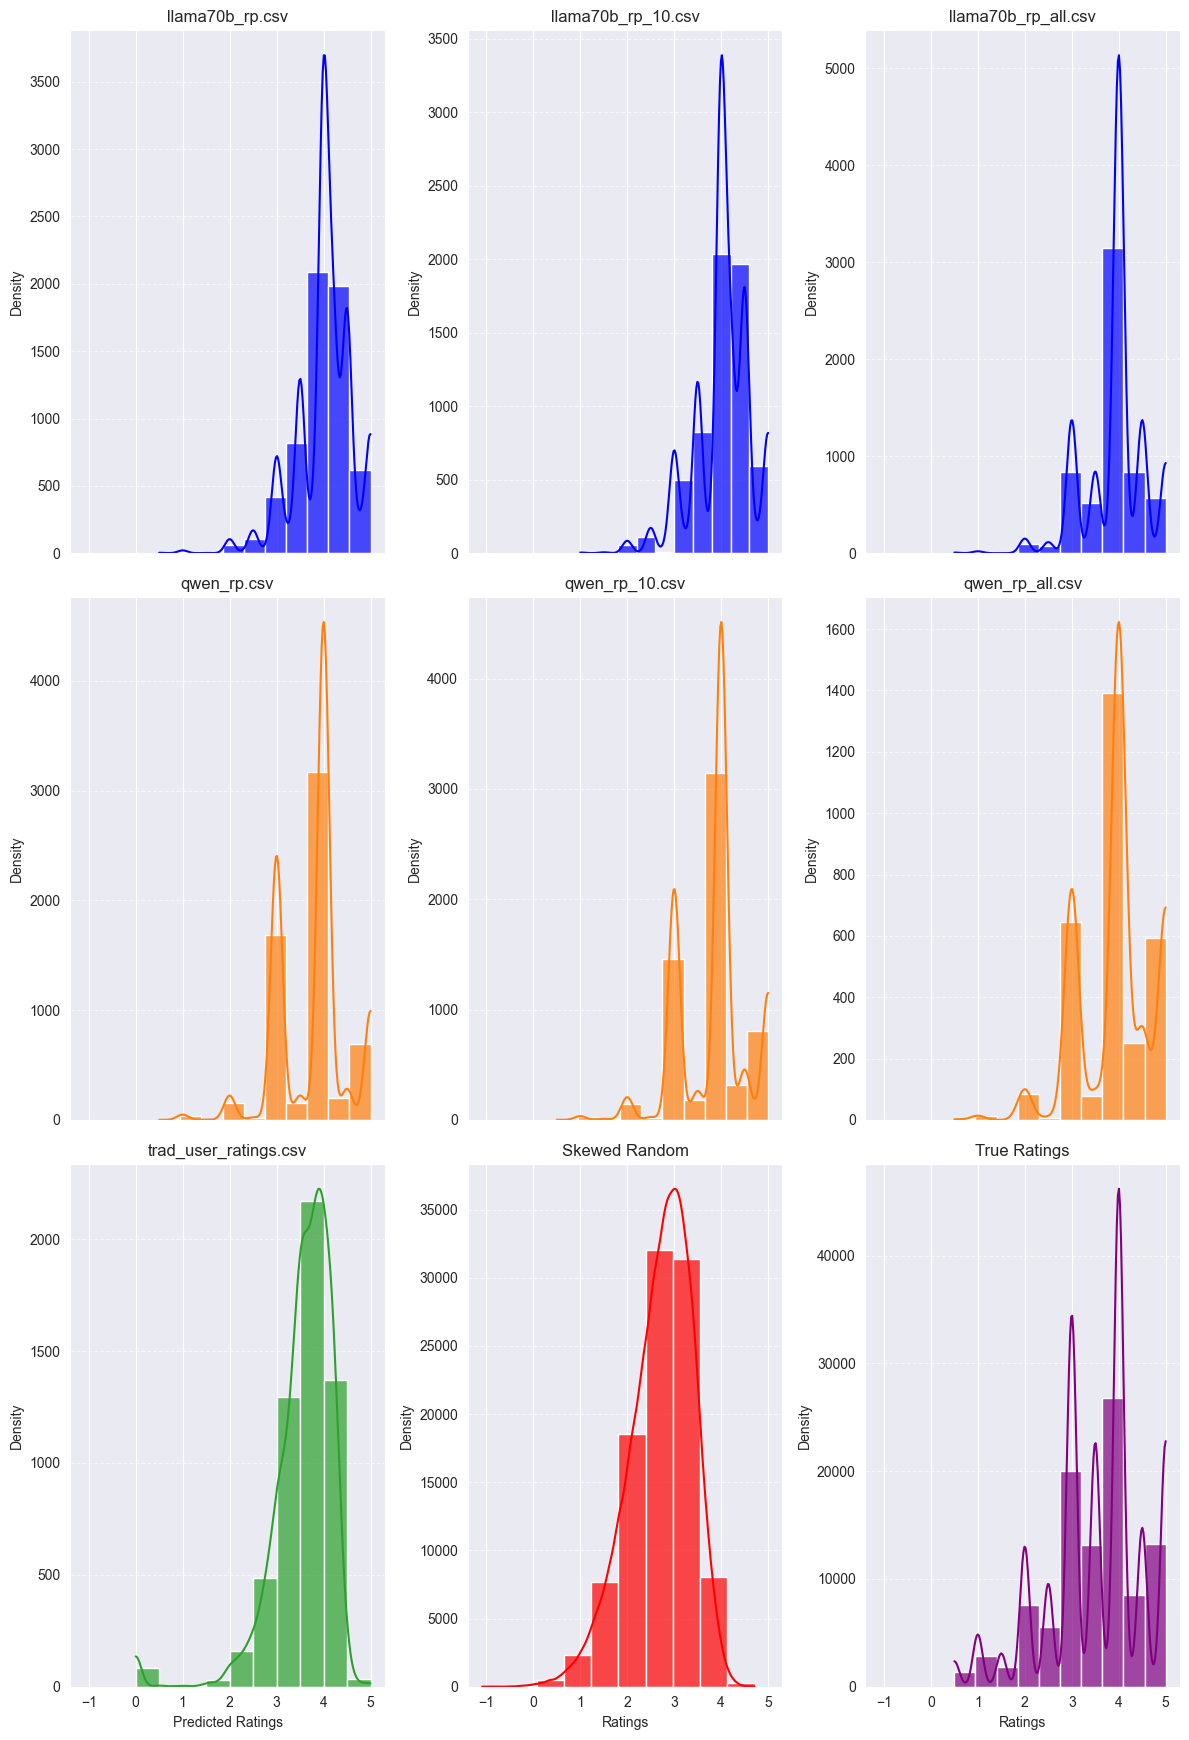

In [101]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# List of CSV files to process
csv_files = [f for f in glob.glob(os.path.join('llm_output_processed', "*.csv"))] + ['user_based/trad_user_ratings.csv']
csv_files.sort()

# Determine the number of subplots needed
n_plots = len(csv_files)

# Create a figure with multiple subplots
nCol = 3
fig, axes = plt.subplots(nrows=(n_plots // nCol) + 1, ncols=nCol, figsize=(12, 2.5 * n_plots), sharex=True)

# Function to determine color based on filename prefix
def determine_color(filename):
    if filename.startswith('qwen'):
        return '#ff7f0e'
    elif filename.startswith('trad'):
        return '#2ca02c'
    elif filename.startswith('Random'):
        return '#d62728'
    else:
        return 'blue'  # Default color

# Iterate over each file and plot its distribution
for i, file in enumerate(csv_files):
    print(file)
    predicted_df = pd.read_csv(file).dropna()

    # Check if 'predicted_rating' column exists
    if 'predicted_rating' not in predicted_df.columns:
        print(f"Warning: 'predicted_rating' column not found in {file}")
        continue

    # Determine the color based on the filename prefix
    color = determine_color(os.path.basename(file))

    # Plot the distribution on the corresponding subplot
    sns.histplot(predicted_df['predicted_rating'], bins=10, kde=True, color=color, alpha=0.7, ax=axes[i // nCol][i % nCol])
    axes[i // nCol][i % nCol].set_xlabel('Predicted Ratings')
    axes[i // nCol][i % nCol].set_ylabel('Density')
    axes[i // nCol][i % nCol].set_title(f'{os.path.basename(file)}')
    axes[i // nCol][i % nCol].grid(axis='y', linestyle='--', alpha=0.7)



sns.histplot(skewed_data, bins=10, kde=True, color='red', alpha=0.7, ax=axes[-1][-2])
axes[-1][-2].set_xlabel('Ratings')
axes[-1][-2].set_ylabel('Density')
axes[-1][-2].set_title(f'Skewed Random')
axes[-1][-2].grid(axis='y', linestyle='--', alpha=0.7)

sns.histplot(df['rating'], bins=10, kde=True, color='purple', alpha=0.7, ax=axes[-1][-1])
axes[-1][-1].set_xlabel('Ratings')
axes[-1][-1].set_ylabel('Density')
axes[-1][-1].set_title(f'True Ratings')
axes[-1][-1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('distributions.png')

# Show the plot
plt.show()

llm_output_processed/llama70b_rp.csv
llm_output_processed/llama70b_rp_10.csv
llm_output_processed/llama70b_rp_all.csv
llm_output_processed/qwen_rp.csv
llm_output_processed/qwen_rp_10.csv
llm_output_processed/qwen_rp_all.csv
user_based/trad_user_ratings.csv


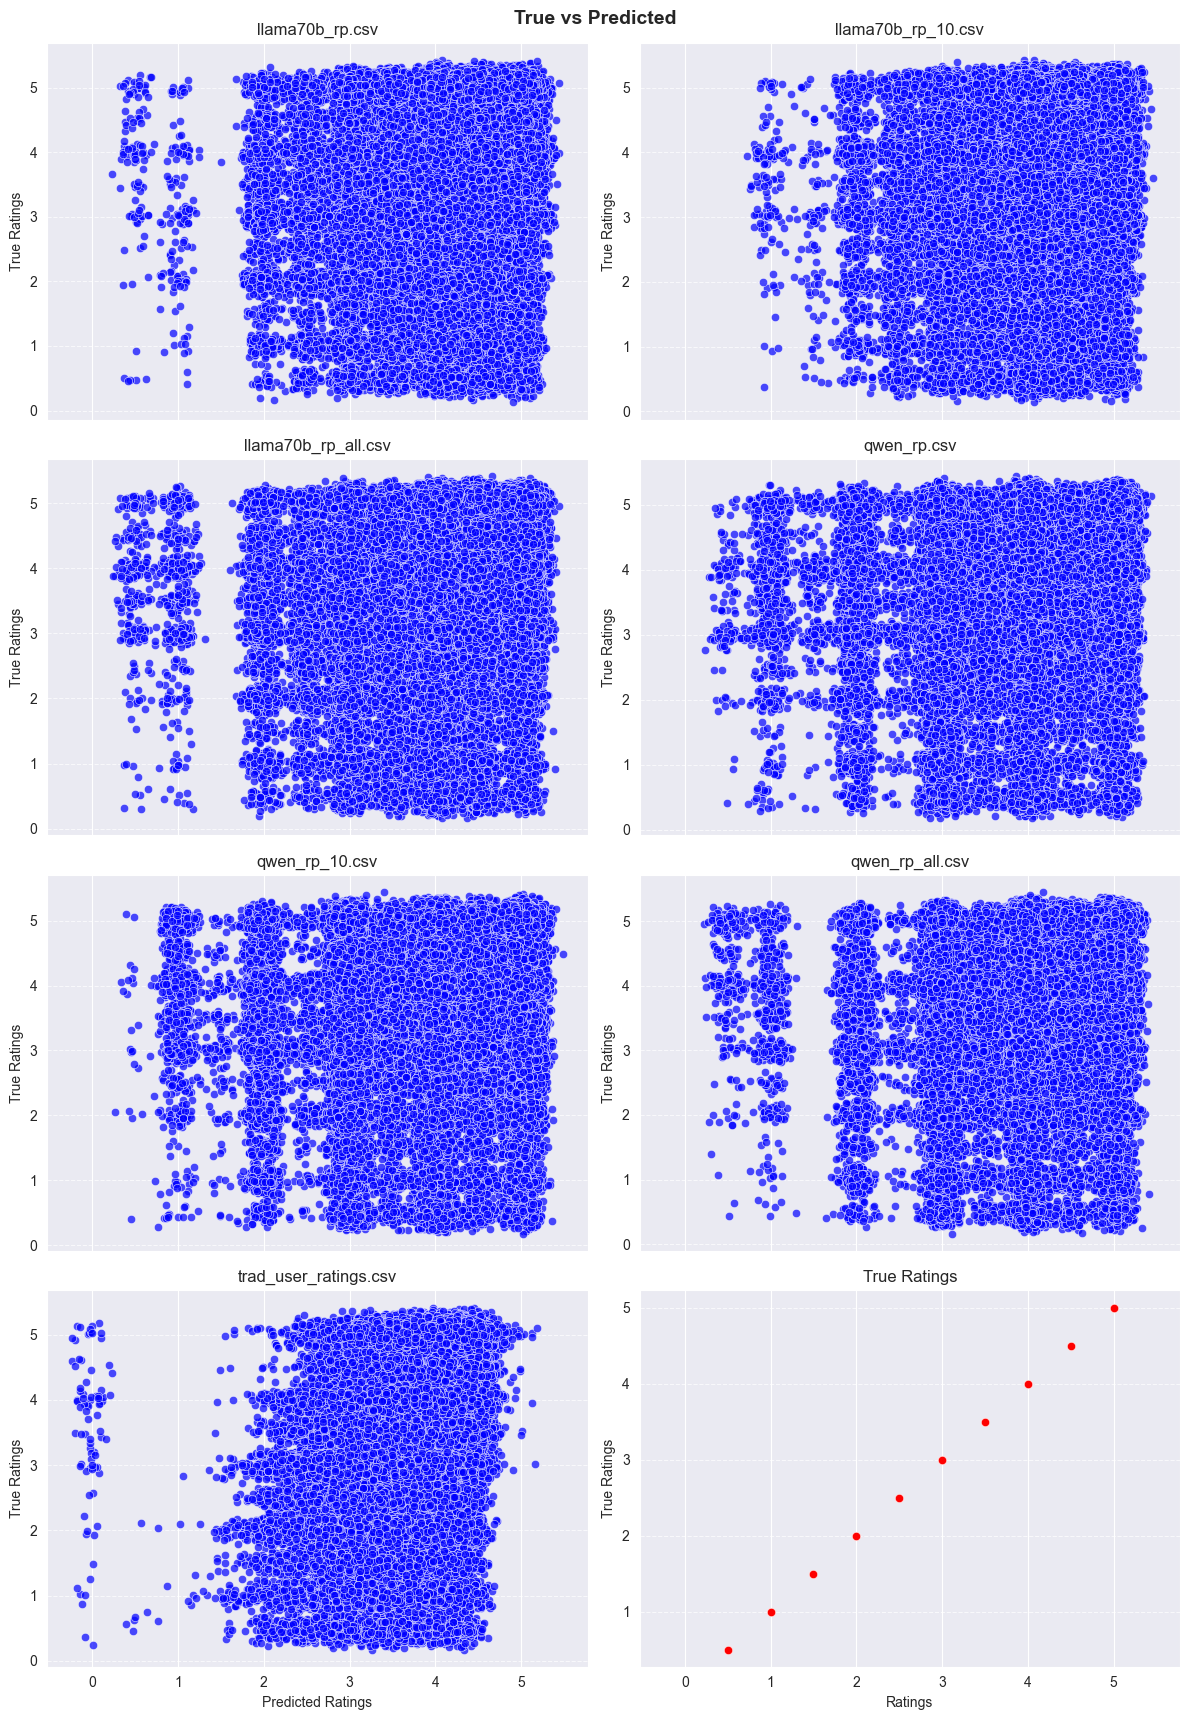

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



# Determine the number of subplots needed
n_plots = len(csv_files)

# Create a figure with multiple subplots
nCol = 2
fig, axes = plt.subplots(nrows=n_plots//nCol+1, ncols=nCol, figsize=(12, 2.5 * n_plots), sharex=True)
# plt.figure(figsize=(4,8))
# Iterate over each file and plot its distribution
for i, file in enumerate(csv_files):
    print(file)
    in_df = pd.read_csv(file).dropna()
    predicted_df = pd.merge(in_df, df, on='title').dropna()
    # Check if 'predicted_rating' column exists
    if 'predicted_rating' not in predicted_df.columns:
        print(f"Warning: 'predicted_rating' column not found in {file}")
        continue

    def jitter(values, j):
        return values + np.random.normal(j, 0.1, values.shape)

    # Plot the distribution on the corresponding subplot
    sns.scatterplot(x=jitter(predicted_df['predicted_rating'], 0), y = jitter(predicted_df['rating'], 0), color='blue', alpha=0.7, ax=axes[i//nCol][i%nCol])
    axes[i//nCol][i%nCol].set_xlabel('Predicted Ratings')
    axes[i//nCol][i%nCol].set_ylabel('True Ratings')
    axes[i//nCol][i%nCol].set_title(f'{os.path.basename(file)}')
    axes[i//nCol][i%nCol].grid(axis='y', linestyle='--', alpha=0.7)

sns.scatterplot(x=df['rating'], y = df['rating'], color='red', alpha=0.7, ax=axes[-1][-1])
axes[-1][-1].set_xlabel('Ratings')
axes[-1][-1].set_ylabel('True Ratings')
axes[-1][-1].set_title(f'True Ratings')
axes[-1][-1].grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle('True vs Predicted', fontsize=14, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

llm_output_processed/llama70b_rp.csv
llm_output_processed/qwen_rp.csv
llm_output_processed/qwen_rp_10.csv
llm_output_processed/llama70b_rp_all.csv
llm_output_processed/qwen_rp_all.csv
llm_output_processed/llama70b_rp_10.csv
user_based/trad_user_ratings.csv


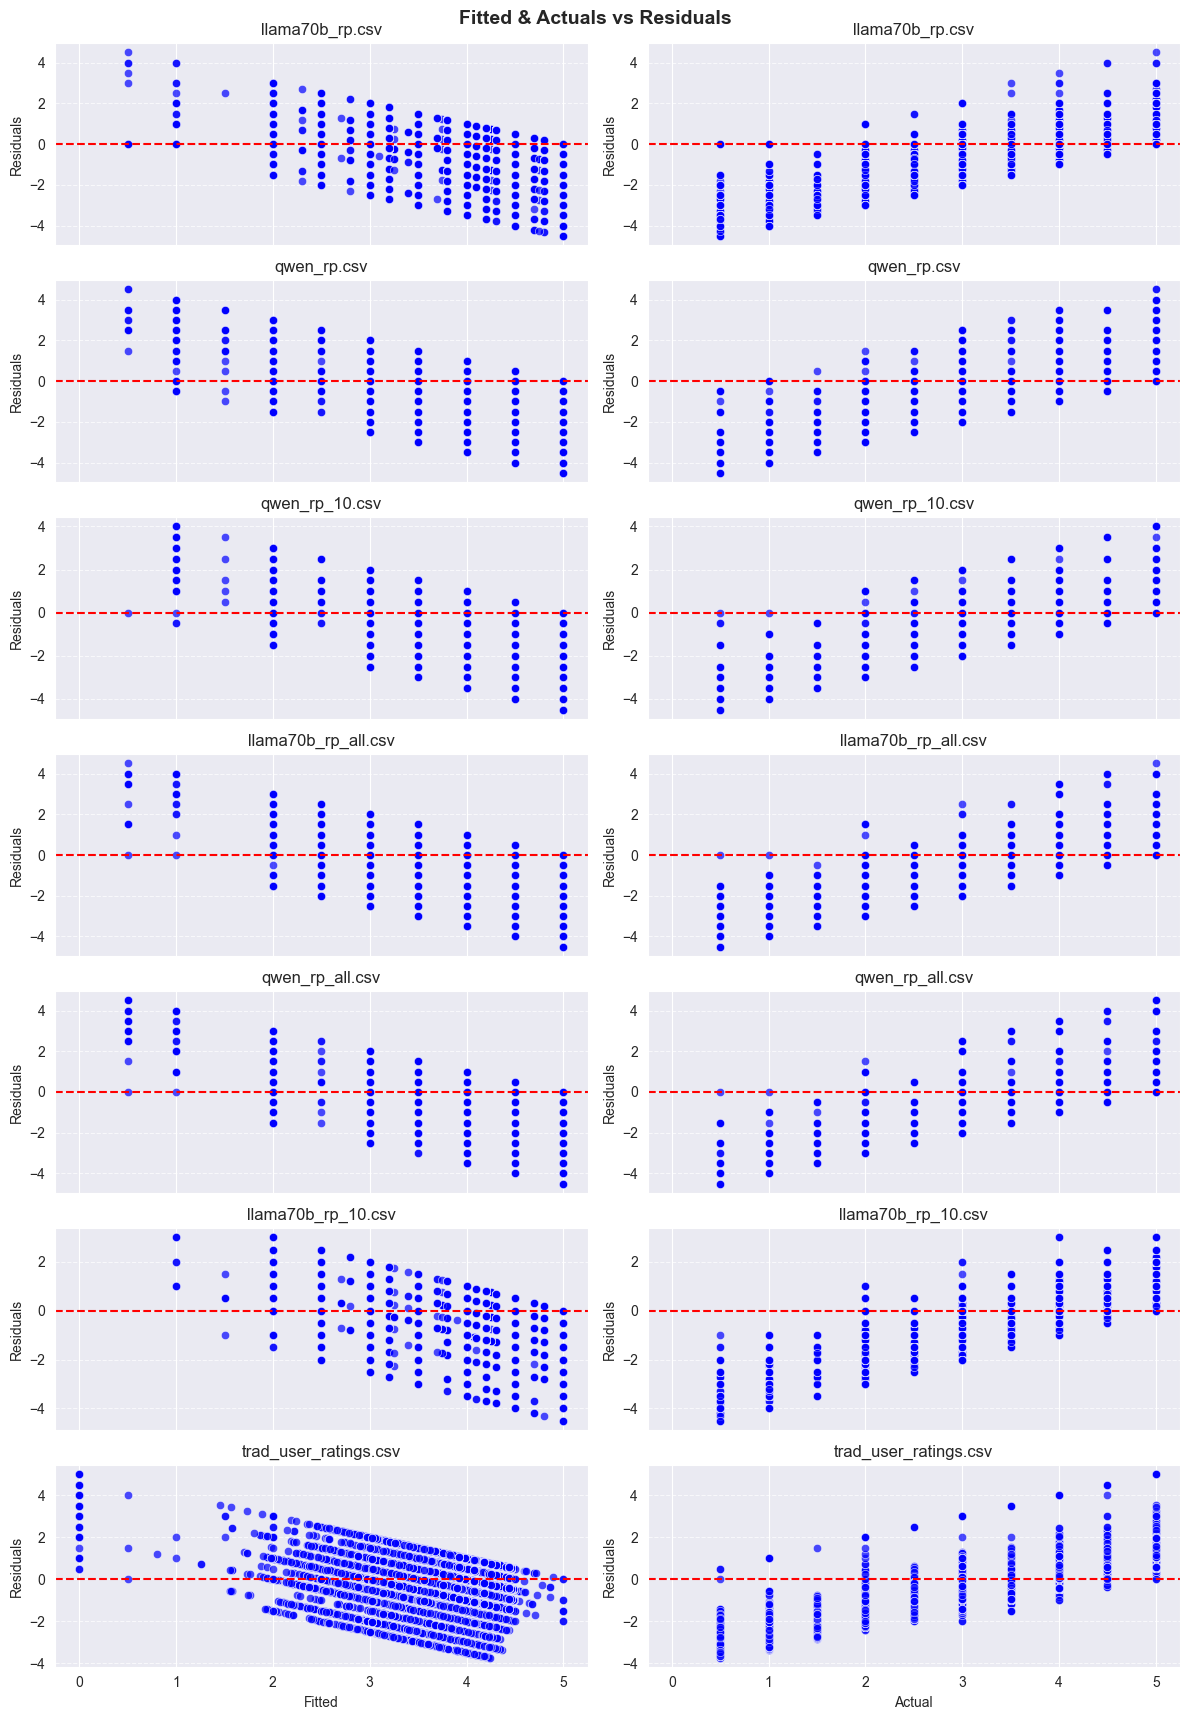

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

csv_files = [f for f in glob.glob(os.path.join('llm_output_processed',
"*.csv"))] + ['user_based/trad_user_ratings.csv']

# Determine the number of subplots needed
n_plots = len(csv_files)

# Create a figure with multiple subplots
nCol = 2
fig, axes = plt.subplots(nrows=n_plots, ncols=nCol, figsize=(12, 2.5 * n_plots), sharex=True)

# Iterate over each file and plot its distribution
for i, file in enumerate(csv_files):
    print(file)
    in_df = pd.read_csv(file).dropna()
    predicted_df = pd.merge(in_df, df, on='title').dropna()
    # Check if 'predicted_rating' column exists
    if 'predicted_rating' not in predicted_df.columns:
        print(f"Warning: 'predicted_rating' column not found in {file}")
        continue

    predicted_df['residuals'] = predicted_df['rating'] - predicted_df['predicted_rating']

    # Plot the distribution on the corresponding subplot
    sns.scatterplot(x=predicted_df['predicted_rating'], y = predicted_df['residuals'], color='blue', alpha=0.7, ax=axes[i][0])
    axes[i][0].axhline(y=0, color='r', linestyle='--')
    axes[i][0].set_xlabel('Fitted')
    axes[i][0].set_ylabel('Residuals')
    axes[i][0].set_title(f'{os.path.basename(file)}')
    axes[i][0].grid(axis='y', linestyle='--', alpha=0.7)

    sns.scatterplot(x=predicted_df['rating'], y = predicted_df['residuals'], color='blue', alpha=0.7, ax=axes[i][1])
    axes[i][1].axhline(y=0, color='r', linestyle='--')
    axes[i][1].set_xlabel('Actual')
    axes[i][1].set_ylabel('Residuals')
    axes[i][1].set_title(f'{os.path.basename(file)}')
    axes[i][1].grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle('Fitted & Actuals vs Residuals', fontsize=14, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()